# <a id='toc1_'></a>[T23 State Space Control](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [T23 State Space Control](#toc1_)    
- [Combined estimator/regulator design for a simple satellite model](#toc2_)    
- [follows FPE 9.2 (fourth edition)](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not` found - downloading it')
    for dfile in File:
        if not os.path.isfile(dfile):
            print(dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()
else:
    print('Basic file found')
from basic_material import *

j = complex(0,1)

from scipy.optimize import minimize
from scipy.signal import butter,bessel
from control.matlab import tf, ss, ss2tf, step, place, rlocus, lqr, lsim, ssdata
from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.3
Control Package Found
This is a library of basic functions for 16.06
This is a library of useful functions for the control systems in 16.06


# <a id='toc2_'></a>[Combined estimator/regulator design for a simple satellite model](#toc0_)
# <a id='toc3_'></a>[follows FPE 9.2 (fourth edition)](#toc0_)

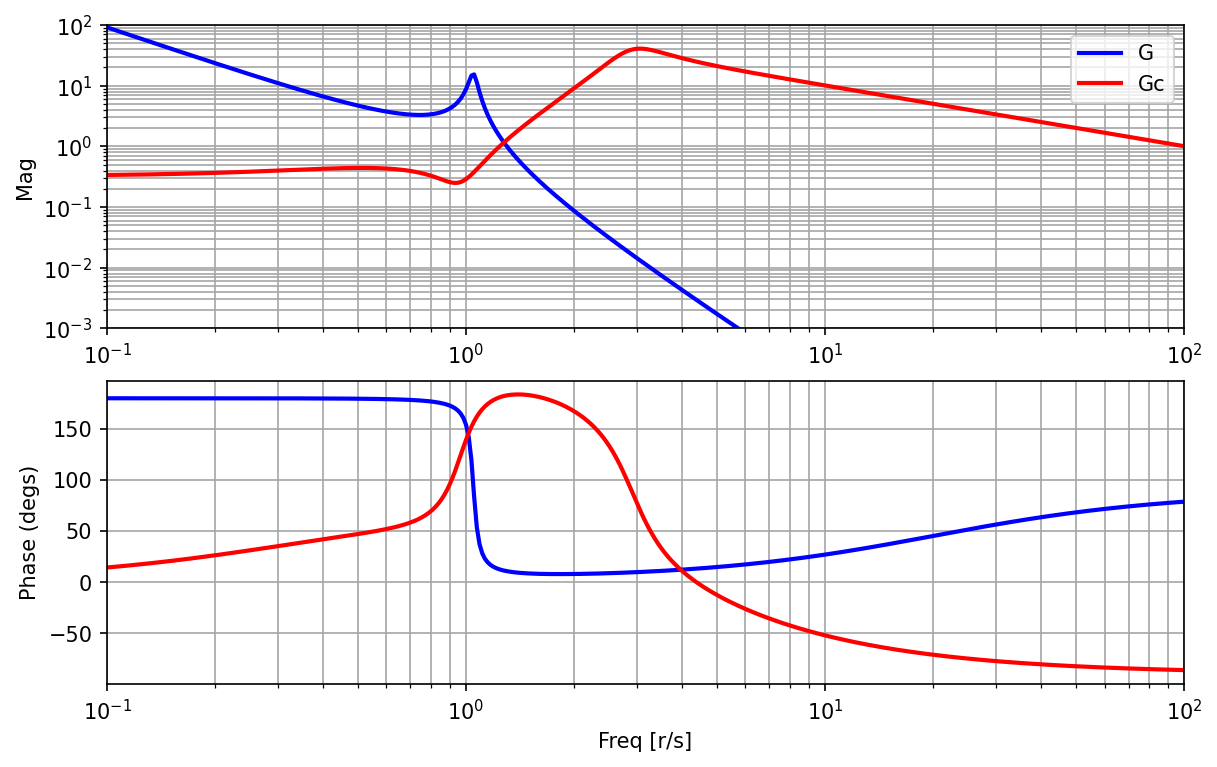

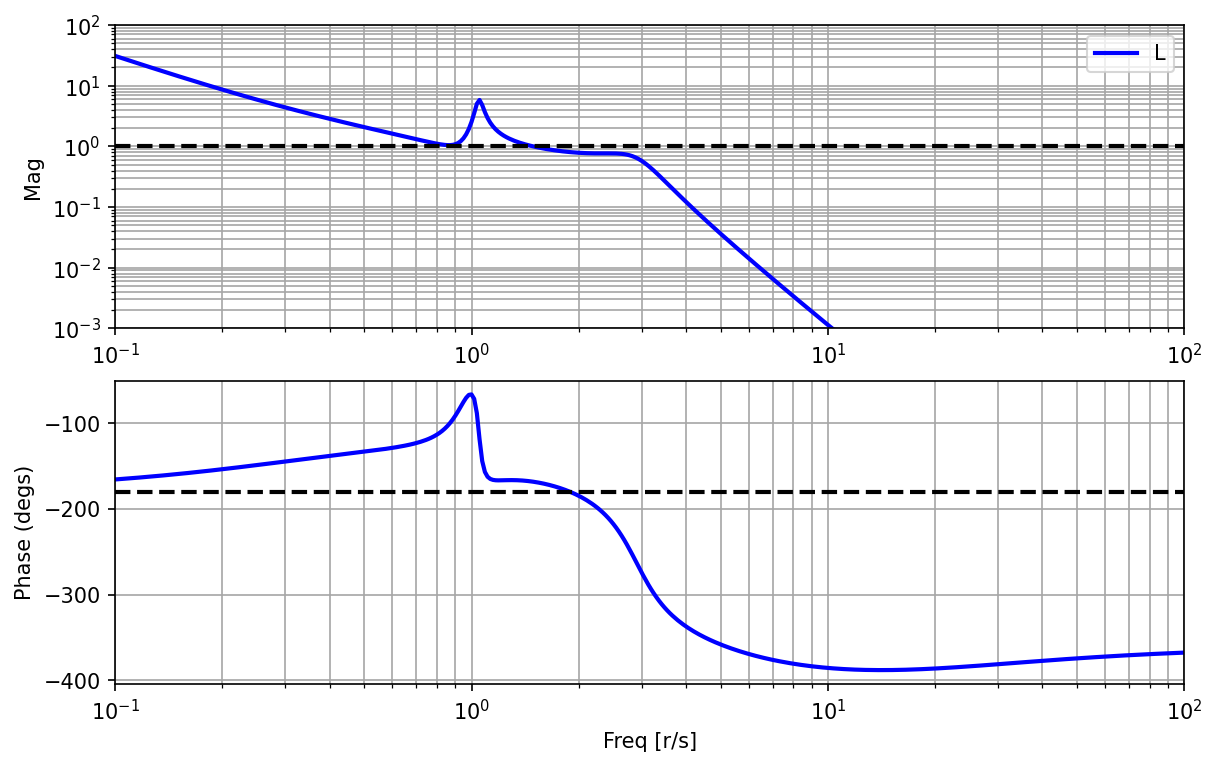


Found breakin/out at K = 1.011
At possible locations s = -1.352

Found breakin/out at K = 0.000
At possible locations s = -0.000


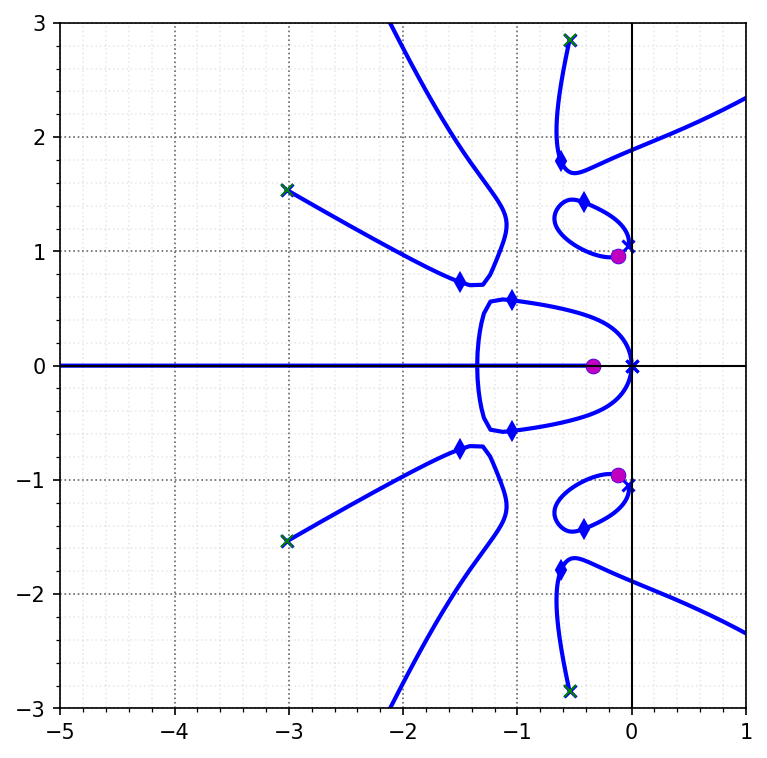

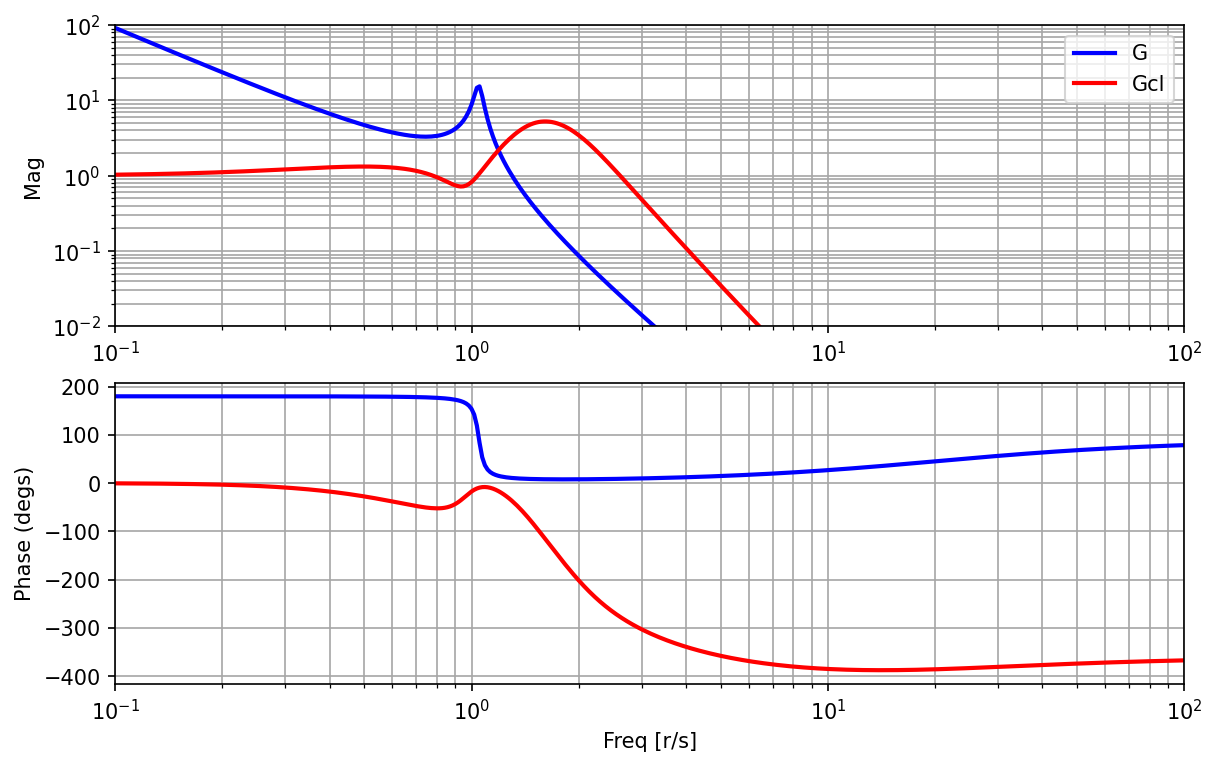

In [2]:
kk = 0.1
bb = 0.05*np.sqrt(kk/10)
J1 = 1
J2 = 0.1
a = np.array([[0, 1, 0, 0],[-kk/J2, -bb/J2, kk/J2, bb/J2],[0, 0, 0, 1],[kk/J1, bb/J1, -kk/J1, -bb/J1]])
nx = a.shape[0]
b = np.array([0, 0, 0, 1/J1]).reshape(nx,1);
c = np.array([1, 0, 0, 0])
d = 0

# design DOFB controller
k,_,_ = lqr(a,b,c.reshape(nx,1)*c,.1)
k = np.squeeze(np.asarray(k))
l,_,_ = lqr(a.transpose(),c.reshape(nx,1),b*b.reshape(1,nx),.01)
l = np.squeeze(np.asarray(l))
l = l.reshape(nx,1)
#
# For state space for G_c(s)
#
ac = a-b*k-l*c
bc = l
cc = k
dc = 0

G = ss(a,b,c,d);
Gc = ss(ac,bc,cc,dc)
L = G*Gc

w = np.logspace(-1,2,400)
Gf = G(w*j)
Gcf = Gc(j*w)
Lf = L(j*w)
#
# loop dynamics L = G Gc
#
al = np.vstack((np.hstack((a,b*cc)),np.hstack((np.zeros((nx,nx)),ac))))
bl = np.vstack((np.zeros((nx,1)), bc ))
cl = np.hstack((c.reshape(1,nx), np.zeros((1,nx)) ))
dl = 0
L = ss2tf(al,bl,cl,dl)
#
# closed-loop dynamics
# unity gain wrapped around loop L
#
acl = al - bl*cl
bcl = bl 
ccl = cl
dcl = d
# scale closed-loop to get zero SS error
N = np.linalg.inv(ccl@np.linalg.inv(-acl)@bcl)

Gcl = ss2tf(acl,bcl*N,ccl,dcl*N)
scl = Gcl.poles()
sc = Gc.poles()
zc = Gc.zeros()
Gclf = Gcl(j*w)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
ax[0].loglog(w,np.abs(Gcf),'r',label=r'Gc')
ax[1].semilogx(w,np.unwrap(np.angle(Gcf))*r2d,'r',label=r'Gc')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].legend()
ax[0].set_ylim(1e-3,100)
savefig("figs/DOFB_sat_0.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Lf),'b',label=r'L')
ax[1].semilogx(w,np.unwrap(np.angle(Lf))*r2d,'b',label=r'L')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].axhline(y=1,c='k',ls='--')
ax[1].axhline(y=-180,c='k',ls='--')
ax[0].legend()
ax[0].set_ylim(1e-3,100)
savefig("figs/DOFB_sat_1.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlist, klist = rlocus(L, kvect=Root_Locus_gains(L,Krange = np.logspace(-3, 3, num=10000)),   grid=False,ax=ax,color='b')
plt.plot(np.real(scl),np.imag(scl),'bd')
plt.plot(np.real(sc),np.imag(sc),'gx')
plt.plot(np.real(zc),np.imag(zc),'mo')
ax.set_aspect('equal')
ax.set_xlim([-5, 1]);
ax.set_ylim([-3, 3])
nicegrid(ax)
savefig("figs/DOFB_sat_2.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
ax[0].loglog(w,np.abs(Gclf),'r',label=r'Gcl')
ax[1].semilogx(w,np.unwrap(np.angle(Gclf))*r2d,'r',label=r'Gcl')
ax[1].set_xlabel('Freq [r/s]')
ax[0].set_ylabel('Mag')
ax[1].set_ylabel('Phase (degs)')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
ax[0].legend()
ax[0].set_ylim(1e-2,100)
savefig("figs/DOFB_sat_3.pdf", dpi=600)
plt.show()

In [3]:
#
# try classical design
#
Klead = 1.5*tf([3, 1],[1, 5]);
Kleadf = Klead(w*j)
LLead = G*Klead
LLeadf = LLead(j*w)
Gcl_Lead = feedback(LLead,1)
scl_Lead = Gcl_Lead.poles()

KleadNotch = Klead*tf([1, 0, .9**2],[1, 2*25, 25**2])/.9**2*25**2;
KleadNotchf = KleadNotch(w*j)

LLeadNotch = G*KleadNotch
LLeadNotchf = LLeadNotch(j*w)
Gcl_LeadNotch = feedback(LLeadNotch,1)
scl_LeadNotch = Gcl_LeadNotch.poles()

if 0:
    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(Kleadf),'r',label=r'Lead')
    ax[1].semilogx(w,np.unwrap(np.angle(Kleadf))*r2d,'r',label=r'Lead')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].legend()
    ax[0].set_ylim(1e-3,100)
    savefig("figs/DOFB_sat_6.pdf", dpi=600)
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(LLeadf),'b',label=r'L Lead')
    ax[1].semilogx(w,np.unwrap(np.angle(LLeadf))*r2d,'b',label=r'L Lead')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].legend()
    ax[0].set_ylim(1e-3,100)
    savefig("figs/DOFB_sat_6a.pdf", dpi=600)
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(Gf),'b',label=r'G')
    ax[1].semilogx(w,np.unwrap(np.angle(Gf))*r2d,'b',label=r'G')
    ax[0].loglog(w,np.abs(KleadNotchf),'r',label=r'Lead')
    ax[1].semilogx(w,np.unwrap(np.angle(KleadNotchf))*r2d,'r',label=r'Lead')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].legend()
    ax[0].set_ylim(1e-3,100)
    savefig("figs/DOFB_sat_7.pdf", dpi=600)
    plt.show()

    fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,constrained_layout = True)
    ax[0].loglog(w,np.abs(LLeadNotchf),'b',label=r'L Lead Notch')
    ax[1].semilogx(w,np.unwrap(np.angle(LLeadNotchf))*r2d,'b',label=r'L Lead Notch')
    ax[1].set_xlabel('Freq [r/s]')
    ax[0].set_ylabel('Mag')
    ax[1].set_ylabel('Phase (degs)')
    ax[0].grid(True, which="both", ls="-",color='0.65')
    ax[1].grid(True, which="both", ls="-",color='0.65')
    ax[0].axhline(y=1,c='k',ls='--')
    ax[1].axhline(y=-180,c='k',ls='--')
    ax[0].legend()
    ax[0].set_ylim(1e-3,100)
    savefig("figs/DOFB_sat_8.pdf", dpi=600)
    plt.show()



Found breakin/out at K = 21.045
At possible locations s = -3.750

Found breakin/out at K = 1.938
At possible locations s = -0.579

Found breakin/out at K = 0.000
At possible locations s = -0.000


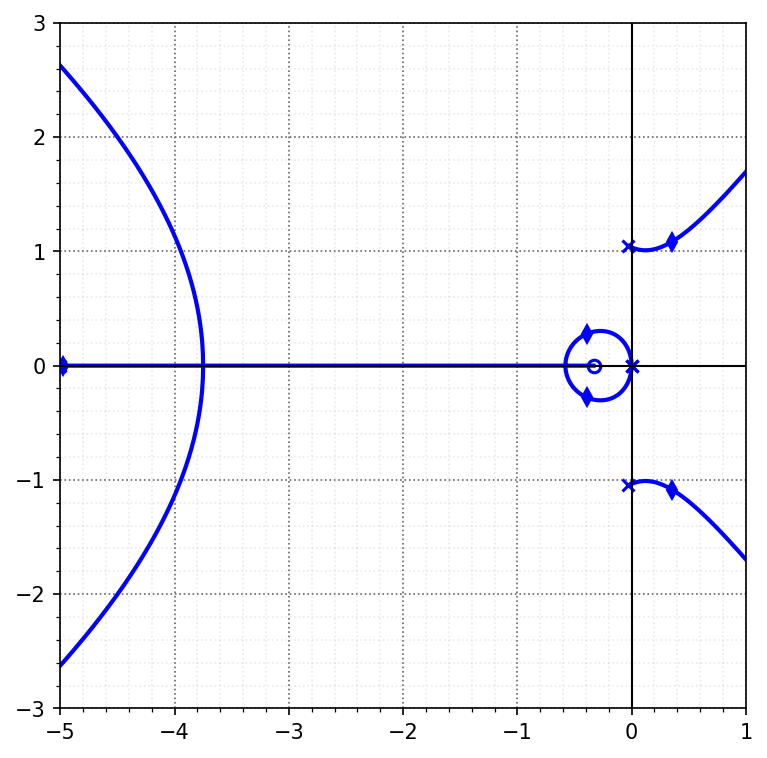


Found breakin/out at K = 1.265
At possible locations s = -1.971

Found breakin/out at K = 1.179
At possible locations s = -0.888

Found breakin/out at K = 0.000
At possible locations s = -0.000, -25.000


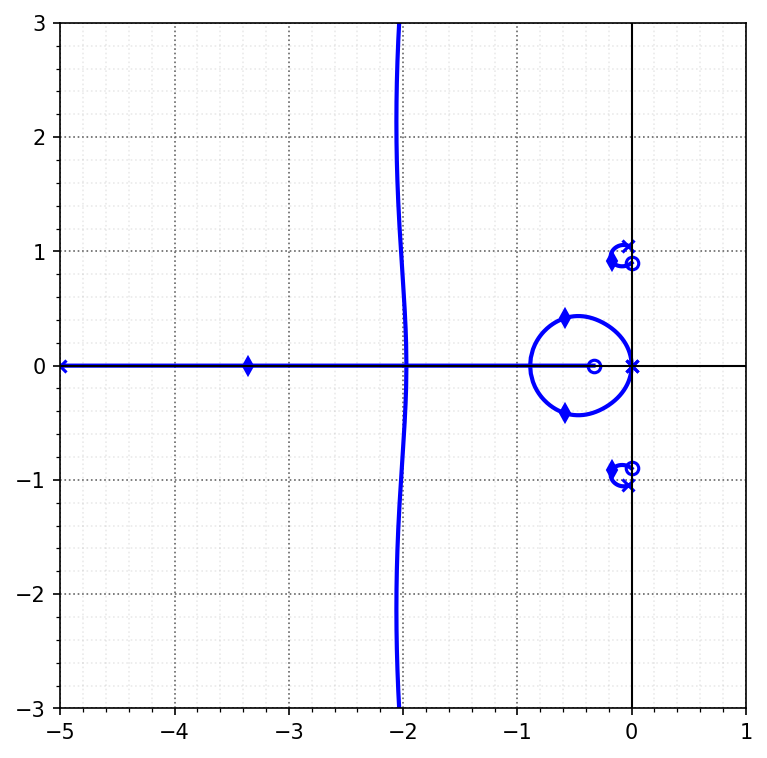

In [4]:
fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlist, klist = rlocus(LLead, kvect=Root_Locus_gains(ss2tf(LLead)), grid=False,ax=ax,color='b')
ax.set_aspect('equal')
ax.set_xlim([-5, 1])
ax.set_ylim([-3, 3])
plt.plot(np.real(scl_Lead),np.imag(scl_Lead),'bd')
nicegrid(ax)
savefig("figs/DOFB_sat_9.pdf", dpi=600)
plt.show()

fig, ax = plt.subplots(1,figsize=(5, 5),dpi=150,constrained_layout = True)
rlist, klist = rlocus(LLeadNotch, kvect=Root_Locus_gains(ss2tf(LLeadNotch)),  grid=False,ax=ax,color='b')
ax.set_aspect('equal')
ax.set_xlim([-5, 1]);
ax.set_ylim([-3, 3])
plt.plot(np.real(scl_LeadNotch),np.imag(scl_LeadNotch),'bd')
nicegrid(ax)
savefig("figs/DOFB_sat_10.pdf", dpi=600)
plt.show()


In [15]:
l

array([[   4.184],
       [   8.754],
       [  13.292],
       [   9.125]])

In [16]:
c

array([1, 0, 0, 0])

In [9]:
l*c

array([[   4.184,    0.000,    0.000,    0.000],
       [   8.754,    0.000,    0.000,    0.000],
       [  13.292,    0.000,    0.000,    0.000],
       [   9.125,    0.000,    0.000,    0.000]])

In [11]:
np.matmul(l,c)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

In [13]:
np.outer(l,c)

array([[   4.184,    0.000,    0.000,    0.000],
       [   8.754,    0.000,    0.000,    0.000],
       [  13.292,    0.000,    0.000,    0.000],
       [   9.125,    0.000,    0.000,    0.000]])

In [14]:
l@c

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 1)

In [17]:
b

array([[   0.000],
       [   0.000],
       [   0.000],
       [   1.000]])

In [18]:
k

array([  -0.859,    2.811,    4.021,    2.880])

In [19]:
b*k

array([[  -0.000,    0.000,    0.000,    0.000],
       [  -0.000,    0.000,    0.000,    0.000],
       [  -0.000,    0.000,    0.000,    0.000],
       [  -0.859,    2.811,    4.021,    2.880]])